In [2]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

In [3]:
train=pd.read_csv('train.csv', encoding = 'cp949')
test=pd.read_csv('test.csv', encoding = 'cp949')
submission=pd.read_csv('sample_submission.csv', encoding = 'cp949')

In [4]:
len(train)

122400

In [5]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [6]:
#test.shape 10080 X 9
#60개의 건물 X 7일 24시간 =10080
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
submission.head()

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0


In [8]:
print(train.shape)
print(test.shape)
print(submission.shape)

(122400, 10)
(10080, 9)
(10080, 2)


In [9]:
## 데이터셋의 column별 정보를 알려줌.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


train 데이터셋은 결측값이 없음을 알 수 있다.

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


    test 데이터셋에서는 생각보다 많은 결측값들이 존재하는걸 확인할 수 있다.
    주로, 기온, 풍속, 습도, 일조는 6,720개의 결측값이 존재한다.

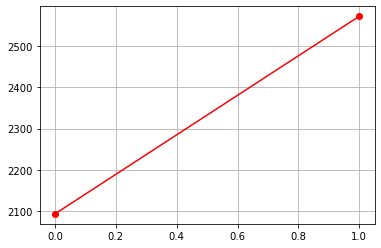

In [15]:
plt.plot(train.groupby('태양광보유').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

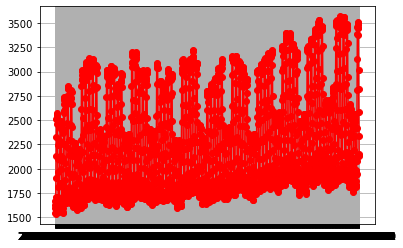

In [16]:
plt.plot(train.groupby('date_time').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

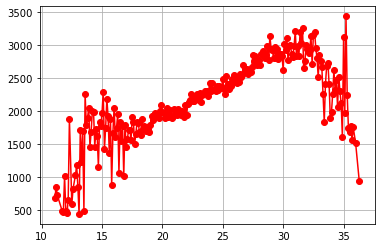

In [18]:
plt.plot(train.groupby('기온(°C)').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

    20도에서 30도까지는 기온이 올라감에 따라 전력사용량도 함께 증가하고 있다.
    10도에서 15도 구간은 기온이 낮아짐에 따라 약간의 상승폭이 나타나는 것을 확인할 수 있다.

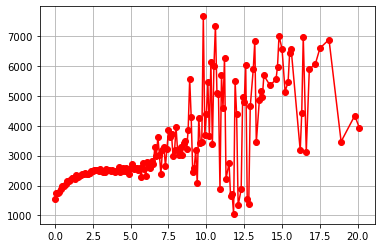

In [19]:
plt.plot(train.groupby('풍속(m/s)').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

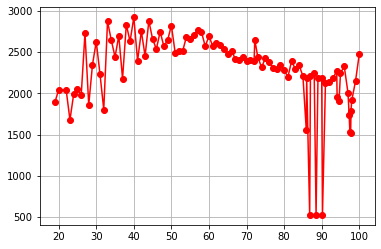

In [20]:
plt.plot(train.groupby('습도(%)').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

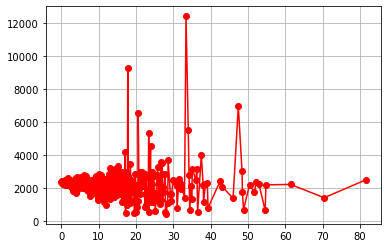

In [22]:
plt.plot(train.groupby('강수량(mm)').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

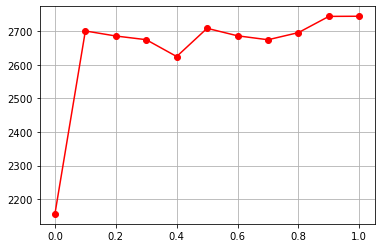

In [23]:
plt.plot(train.groupby('일조(hr)').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

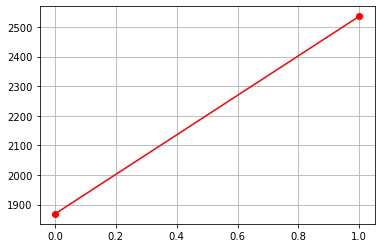

In [24]:
plt.plot(train.groupby('비전기냉방설비운영').mean()['전력사용량(kWh)'], 'ro-')
plt.grid()

<AxesSubplot:>

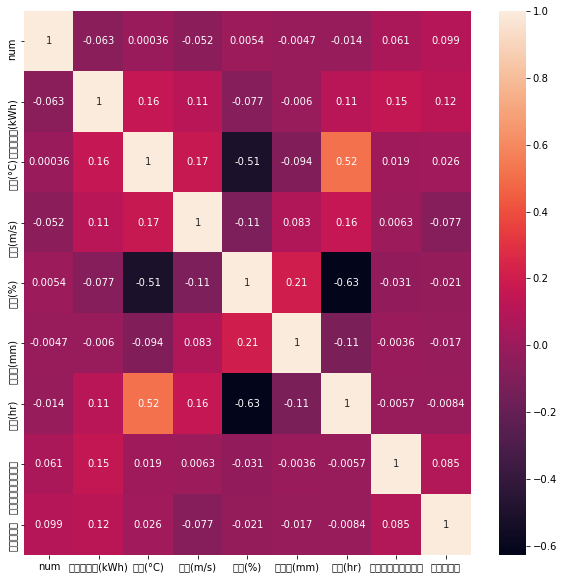

In [28]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot = True)

# 보통 0.4 이상이면 두 개의 변수간에 상관성이 있다고 봄.

    data_time 데이터는 숫자형 데이터가 아니기 때문에 위 자료에 표시되지 않았음.
    num을 제외한 나머지 7개의 데이터는 전력사용량(kWh)와 큰 연관성을 가지지 않는 것을 확인할 수 있음.
    사실상, 다른 데이터보다 시간 및 월별에 따른 숫자형 데이터를 추출해내어 연관성을 찾는 작업이 더 효율적으로 보임.

# **데이터 전처리**

In [11]:
test[test['태양광보유'].isna()]

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10073,60,2020-08-31 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


8456개의 결측값이 존재함.

In [12]:
test[test['비전기냉방설비운영'].isna()]

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10073,60,2020-08-31 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7784개의 결측값이 존재함.

In [17]:
test.loc[0]

num                         1
date_time       2020-08-25 00
기온(°C)                   27.8
풍속(m/s)                   1.5
습도(%)                      74
강수량(mm, 6시간)                0
일조(hr, 3시간)                 0
비전기냉방설비운영                 NaN
태양광보유                     NaN
Name: 0, dtype: object

test 데이터셋의 0번째 데이터를 보면 비전기냉방설비운영 및 태양광 보유 데이터가 null 값인 걸 확인할 수 있음.

In [18]:
#건물별로 '비전기냉방설비운영'과 '태양광보유'를 판단해 test set의 결측치를 보간해줍니다
train[['num', '비전기냉방설비운영','태양광보유']]
ice={} 
hot={}
count=0
for i in range(0, len(train), len(train)//60): # // : 나누기 연산 후 소수점 이하의 수를 버리고, 정수 부분의 수만 구함
# range(start, stop, step)

    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']
    

train 데이터셋의 1번째, 2041번째, 4081번째 등등 비전기냉방설비운영 및 태양광 보유 데이터를 ice와 hot에 저장.

In [19]:
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

ice와 hot에 각각 추려진 60개의 데이터를 건물별(1번 건물 ~ 60번 건물)까지 값을 대입함.

In [25]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [51]:
test.loc[1300]

num                         8
date_time       2020-08-30 04
기온(°C)                    NaN
풍속(m/s)                   NaN
습도(%)                     NaN
강수량(mm, 6시간)              NaN
일조(hr, 3시간)               NaN
비전기냉방설비운영                   1
태양광보유                       1
Name: 1300, dtype: object

In [53]:
test.loc[1301]

num                         8
date_time       2020-08-30 05
기온(°C)                    NaN
풍속(m/s)                   NaN
습도(%)                     NaN
강수량(mm, 6시간)              NaN
일조(hr, 3시간)               NaN
비전기냉방설비운영                   1
태양광보유                       1
Name: 1301, dtype: object

    test 데이터에서 건물별 '비전기냉방설비운영', '태양광보유' 값이 모두 동일하게 바뀐 것을 확인할 수 있다.
    EX) num = 8인 건물들(약 1200번 데이터부터 약 1300번 데이터까지)은 위 데이터 값이 동일하게 변경됨을 확인할 수 있음.

In [29]:
#시간 변수와 요일 변수를 추가해봅니다.
def time(x):
    return int(x[-2:])
train['time']=train['date_time'].apply(lambda x: time(x))
test['time']=test['date_time'].apply(lambda x: time(x))

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

+ test 결측치 보간해줍니다.
+ test 데이터의 변수는 예보 데이터이며, 예보 데이터는 train 데이터의 기간에 생성된 것이기에 활용 가능합니다.

In [30]:
test.interpolate(method='values')

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0


# **모델링**

In [31]:
train_x=train.drop('전력사용량(kWh)', axis=1)
train_y=train[['전력사용량(kWh)']]

In [32]:
train_x.drop('date_time', axis=1, inplace=True)
test.drop('date_time', axis=1, inplace=True)

In [33]:
cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

아래 코드는 최정명님의 코드 구성 방식을 살며시 활용했습니다. 감사합니다

https://www.dacon.io/competitions/official/235713/codeshare/2476?page=1&dtype=recent


In [34]:
models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')
    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print(f'================================================\n\n')

====================1=======================
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 110589	valid_1's l2: 110225
Did not meet early stopping. Best iteration is:
[100]	training's l2: 110589	valid_1's l2: 110225


====================2=======================
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 105803	valid_1's l2: 118195
Did not meet early stopping. Best iteration is:
[100]	training's l2: 105803	valid_1's l2: 118195


====================3=======================
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 110710	valid_1's l2: 110163
Did not meet early stopping. Best iteration is:
[100]	training's l2: 110710	valid_1's l2: 110163


====================4=======================
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 110637	valid_1's l2: 112547
Did not meet early stopping. Best iteration is:
[100]	training's l2: 110637	valid_1

In [35]:
for i in range(5):
    submission['answer'] += models[i].predict(test)/5 

In [36]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8498.811895
1,1 2020-08-25 01,8250.686717
2,1 2020-08-25 02,8233.221080
3,1 2020-08-25 03,8475.304267
4,1 2020-08-25 04,8229.168616
...,...,...
10075,60 2020-08-31 19,3132.833178
10076,60 2020-08-31 20,2717.140679
10077,60 2020-08-31 21,2987.995728
10078,60 2020-08-31 22,2528.727359


In [37]:
#제출
submission.to_csv('baseline_submission3.csv', index=False)